## ⭐ cross-samples prediction
## cross-samples prediciton test(auROC,auPRC)，and cross-samples impute test(ns,ls)

In [1]:
import feather
import scanpy as sc
import seaborn as sns
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xchrom as xc

In [2]:
path = '../'
save_path = f'{path}/2_Seurat/Results/'
adata_atac = sc.read_h5ad(f'{path}/0_preprocess/processed_data/test_atac.h5ad')

In [3]:
true = pd.read_feather(f'{save_path}/Seurat_true.feather') 
pred = pd.read_feather(f'{save_path}/Seurat_pred.feather')

### 1- cross-samples prediciton test(auROC,auPRC)

In [4]:
pred.index = pred.loc[:,'index']
pred = pred.drop('index',axis=1)
true.index = true.loc[:,'index']
true = true.drop('index',axis=1)
true = true.T
pred = pred.T

In [5]:
true[true > 1] = 1
true_array = np.array(true,dtype=np.float32)
pred_array = np.array(pred,dtype=np.float32)
print(true_array.shape,pred_array.shape)

(4220, 53735) (4220, 53735)


In [6]:
## -1 Calculate overall auROC & auPRC 
overall_metrics = xc.tl.calc_auc_pr(true_array, pred_array, 'overall')
print(f"Overall auROC: {overall_metrics['auroc']:.4f}, auPRC: {overall_metrics['auprc']:.4f}")

## -2 Calculate per cell auRPC & auPRC
cell_metrics = xc.tl.calc_auc_pr(true_array, pred_array, 'percell')
print(f"Per-cell auROC: {cell_metrics['auroc']:.4f}, auPRC: {cell_metrics['auprc']:.4f}")
print(f"Valid cells: {cell_metrics['n_cells']}")

## -3 Calculate per peak auROC & auPRC
peak_metrics = xc.tl.calc_auc_pr(true_array, pred_array, 'perpeak')
print(f"Per-peak auROC: {peak_metrics['auroc']:.4f}, auPRC: {peak_metrics['auprc']:.4f}")
print(f"Valid peaks: {peak_metrics['n_peaks']}")

Overall auROC: 0.6957, auPRC: 0.1094
Per-cell auROC: 0.6975, auPRC: 0.1085
Valid cells: 4220
Per-peak auROC: 0.5576, auPRC: 0.0576
Valid peaks: 53735


### 2- cross-samples impute test(ns,ls)

In [7]:
rna = sc.read_h5ad(f'{path}/0_preprocess/processed_data/test_rna.h5ad') ## provide X_pca to compute neighbors
rna = xc.tl.calc_pca(rna,max_value=10,n_comps=32)

/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
pred_sort = pred.reindex(index=rna.obs_names, columns=adata_atac.var_names)
print(pred_sort.columns.equals(adata_atac.var_names))
adata_atacp = adata_atac.copy()
adata_atacp.X = np.array(pred_array)
adata_atacp.write_h5ad(f'{save_path}/seurat_imp.h5ad')

True


/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


neighbor score(100)=0.3812,label score(100)=0.7859
neighbor score(50)=0.2989,label score(50)=0.8358
neighbor score(10)=0.1488,label score(10)=0.8667


<AxesSubplot:title={'center':'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

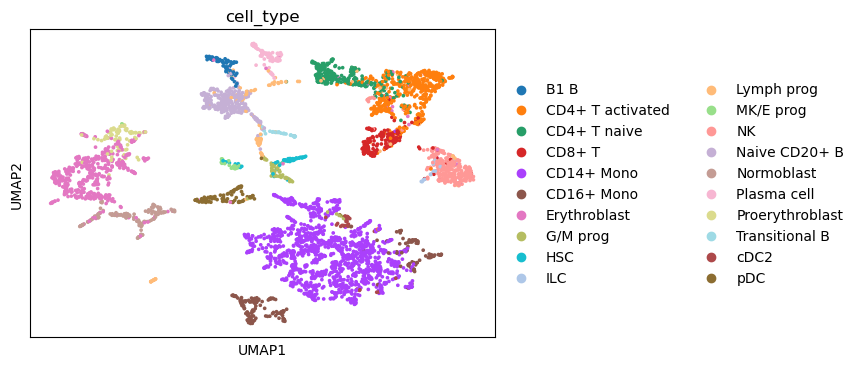

In [9]:
# Seurat impute
ad1 = adata_atacp.copy()
ad1 = xc.tl.calc_pca(ad1)
ns,ls= xc.tl.calc_nsls_score(rna,ad1,100,'cell_type',use_rep_rna = 'X_pca',use_rep_atac='X_pca')
print(f'neighbor score(100)={ns:.4f},label score(100)={ls:.4f}')

ns,ls= xc.tl.calc_nsls_score(rna,ad1,50,'cell_type',use_rep_rna = 'X_pca',use_rep_atac='X_pca')
print(f'neighbor score(50)={ns:.4f},label score(50)={ls:.4f}')

ns,ls= xc.tl.calc_nsls_score(rna,ad1,10,'cell_type',use_rep_rna = 'X_pca',use_rep_atac='X_pca')
print(f'neighbor score(10)={ns:.4f},label score(10)={ls:.4f}')

f, ax = plt.subplots(1, 1, figsize=(6, 4))
sc.pl.umap(ad1, color='cell_type', ax=ax, show=False)